# Neural Network for Ternary Classification of Stress Using Spectograms - Breathing Coils
- There will be three classes: S1, S2 and Rest. This is achieved by combining the S1 and S2 class into one class, Stress
- This network will aim to use just the coils extracted from the data collection.

## Architecture 
- This network has a fetaure extraction for just the coils. These layers are then combined together with a dense layer and then output

In [498]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
import heartpy as hp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import optuna
from optuna.integration import TFKerasPruningCallback
import keras

In [499]:
# Compilation Options
CLASS_WEIGHTS = True
TUNING = True

In [500]:
# Read the CSV file into a DataFrame
file_path = 'filtered_normalized_stress_data.csv'
data = pd.read_csv(file_path)

In [501]:
# Helper function to plot the signals
def plot_figure(signal, title): 
    plt.figure(figsize=(10, 5))
    plt.plot(signal)
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(146751, 4)
classification
S1      50000
Rest    48876
S2      47875
Name: count, dtype: int64
['S2' 'S1' 'Rest']


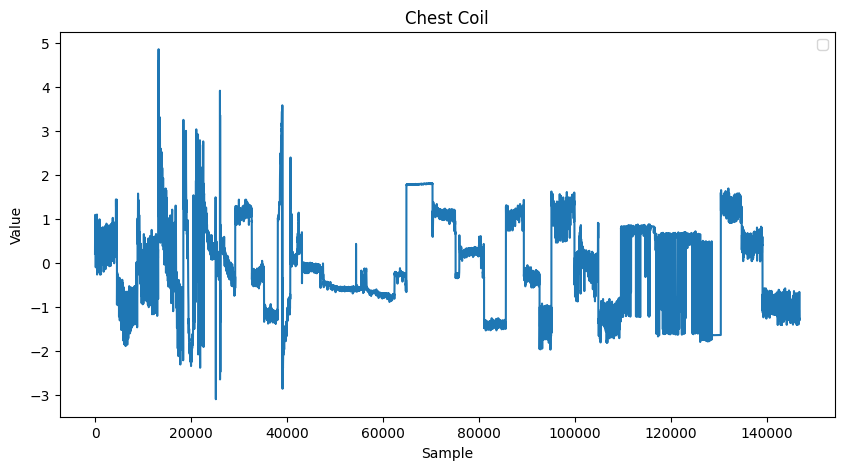

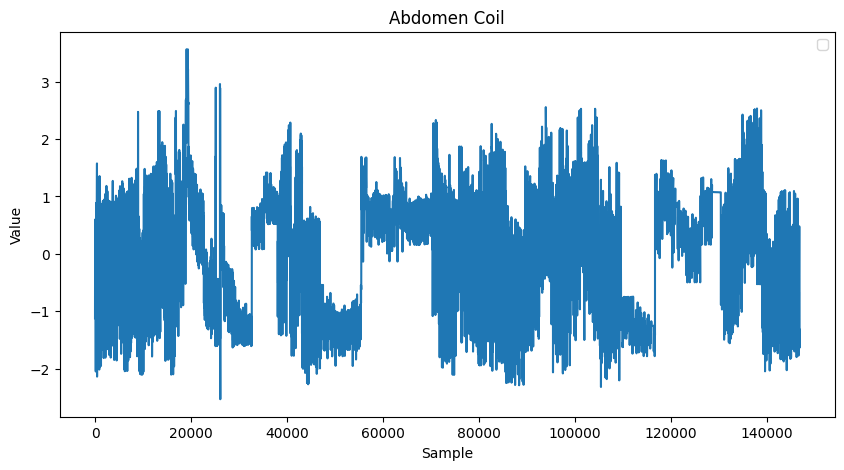

In [502]:
# Columns to extract from the dataset
columns_to_extract = ['user_id', 'classification', 'chest_coil', 'abdomen_coil']
features = ['chest_coil', 'abdomen_coil']

# Extract the specified columns
extracted_columns = data[columns_to_extract]

# Drop any rows with missing data
extracted_columns = extracted_columns.dropna()

# Convert any non numeric data to float or else drop the row
for feature in features:
    extracted_columns[feature] = pd.to_numeric(extracted_columns[feature], errors='coerce')

if extracted_columns.isnull().values.any():
    print("NaNs detected after attempting to convert non-numeric values to float. Please check the data.")
    extracted_columns = extracted_columns.dropna()

print(extracted_columns.shape)

# Ensure we are using the cleaned data for further processing
data = extracted_columns

print(data['classification'].value_counts())
print(data['classification'].unique())

# Plot the signals
plot_figure(data['chest_coil'], 'Chest Coil')
plot_figure(data['abdomen_coil'], 'Abdomen Coil')


In [503]:
# Extract features and labels
X = data[features].values
y = data['classification'].values
user_ids = data['user_id'].values

In [504]:
# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(label_encoder.classes_)

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=3)

['Rest' 'S1' 'S2']


In [505]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [506]:
# Function to compute spectrograms
def compute_spectrogram(signal, fs=1.0, nperseg=64, noverlap=32):
    freqs, times, Sxx = scipy.signal.spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return Sxx

In [507]:
# Reshape data into sequences
time_step_length = 200 
num_samples = len(X_scaled) // time_step_length
fs = 20
spectogram_window = 200
spectogram_overlap = spectogram_window * 0.5

X_sequences = []
for i in range(num_samples):
    sequence = X_scaled[i*time_step_length:(i+1)*time_step_length]
    spectrograms = [compute_spectrogram(sequence[:, j], fs=fs, nperseg=spectogram_window, noverlap=spectogram_overlap) for j in range(sequence.shape[1])]
    X_sequences.append(np.stack(spectrograms, axis=-1))  

X_sequences = np.array(X_sequences)
y_sequences = np.array([y[i*time_step_length] for i in range(num_samples)])
user_id_sequences = np.array([user_ids[i*time_step_length] for i in range(num_samples)])

# Shape: (time, freq, channels)
print(X_sequences.shape)
print(user_id_sequences)

(733, 101, 1, 2)
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5 

In [508]:
# Split the data into training and testing sets based on user_id to avoid data leakage
gkf = GroupKFold(n_splits=5)
for train_index, test_index in gkf.split(X_sequences, y_sequences, groups=user_id_sequences):
    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    break  # Use the first split

# Check the shape of the reshaped data
print("Train: ")
print(X_train.shape)  # Should be (num_samples, time, freq, channels)
print("Test: ")
print(X_test.shape)

Train: 
(572, 101, 1, 2)
Test: 
(161, 101, 1, 2)


In [509]:
# Compute class weights
if CLASS_WEIGHTS:
    y_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
    class_weights_dict = dict(enumerate(class_weights))

In [510]:
# Function to create the CNN for each signal
def create_cnn_branch(input_shape, filters, num_cnn_layers):
    input_signal = Input(shape=input_shape)
    x = input_signal
    
    for i in range(num_cnn_layers):
        x = Conv2D(filters, (3, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 1))(x)
        filters *= 2  # Double the filters for the next layer
    
    x = Flatten()(x)
    model = Model(inputs=input_signal, outputs=x)
    return model

In [511]:
# Objective function for Optuna
def objective(trial):
    # Hyperparameters for tuning 
    filter_1 = trial.suggest_int('filter_1', 64, 256, step=8)
    filter_2 = trial.suggest_int('filter_2', 64, 256, step=8)
    num_cnn_layers_1 = trial.suggest_int('num_cnn_layers_1', 1, 5)
    num_cnn_layers_2 = trial.suggest_int('num_cnn_layers_2', 1, 5)

    filters = [filter_1, filter_2]
    print(filters)
    
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)
    dense_units = [trial.suggest_int(f'dense_units_{i+1}', 32, 256, step=8) for i in range(num_dense_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    _batch_size = 64
    
    # Create input branches for each feature
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    inputs = []

    # Create branches for each signal
    branch1 = create_cnn_branch(input_shape, filter_1, num_cnn_layers_1)
    branch2 = create_cnn_branch(input_shape, filter_2, num_cnn_layers_2)

    # Combine the branches
    concatenated = concatenate([branch1.output, branch2.output])

    # Dense layers
    x = concatenated
    for units in dense_units:
        x = Dense(units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(3, activation='softmax')(x)

    # Create the model
    model = Model(inputs=[branch1.input, branch2.input], outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy')

    # Prepare the training and validation data
    X_train_list = [X_train[:, :, :, i].reshape(-1, X_train.shape[1], X_train.shape[2], 1) for i in range(X_train.shape[3])]
    X_test_list = [X_test[:, :, :, i].reshape(-1, X_test.shape[1], X_test.shape[2], 1) for i in range(X_test.shape[3])]

    # Train the model
    if CLASS_WEIGHTS:
        history = model.fit(X_train_list, y_train, epochs=50, batch_size=_batch_size, validation_data=(X_test_list, y_test),
                            class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping, pruning_callback])
    else:
        history = model.fit(X_train_list, y_train, epochs=50, batch_size=_batch_size, validation_data=(X_test_list, y_test),
                            callbacks=[lr_reduction, early_stopping, pruning_callback])
    
    # Get the best validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy


In [512]:
# Define Hyperparameters
if TUNING:
   # Create an Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, timeout=3600)

    # Print the best trial
    print(f'Best trial: {study.best_trial.number}')
    print(f'Best value (validation accuracy): {study.best_trial.value}')
    print('Best hyperparameters:')
    for key, value in study.best_trial.params.items():
        print(f'    {key}: {value}')


[I 2024-05-27 21:23:28,281] A new study created in memory with name: no-name-cbaaca2b-8521-4749-92d2-05920a0f5be7


[184, 224]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.3909 - loss: 1.7221 - val_accuracy: 0.3789 - val_loss: 1.0989 - learning_rate: 8.0081e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.3905 - loss: 1.2349 - val_accuracy: 0.3478 - val_loss: 1.1016 - learning_rate: 8.0081e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.4190 - loss: 1.1594 - val_accuracy: 0.3292 - val_loss: 1.1022 - learning_rate: 8.0081e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.4788 - loss: 1.1330 - val_accuracy: 0.3292 - val_loss: 1.1003 - learning_rate: 8.0081e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.4145 - loss: 1.0955 - val_accuracy: 0.3230 - val_loss: 1.0946 - learning_rate: 4.0041e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.4797 - loss: 1.0447 - val_accuracy: 0.3478 - val_loss: 1.0996 - learning_rate: 4.0041e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.

[I 2024-05-27 21:25:29,154] Trial 0 finished with value: 0.3788819909095764 and parameters: {'filter_1': 184, 'filter_2': 224, 'num_cnn_layers_1': 4, 'num_cnn_layers_2': 1, 'num_dense_layers': 2, 'dense_units_1': 136, 'dense_units_2': 232, 'dropout_rate': 0.3, 'learning_rate': 0.0008008143892004647}. Best is trial 0 with value: 0.3788819909095764.


[208, 256]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 983ms/step - accuracy: 0.3321 - loss: 1.4449 - val_accuracy: 0.2422 - val_loss: 1.0996 - learning_rate: 1.2096e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 871ms/step - accuracy: 0.3325 - loss: 1.1710 - val_accuracy: 0.3354 - val_loss: 1.1010 - learning_rate: 1.2096e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 899ms/step - accuracy: 0.4220 - loss: 1.1085 - val_accuracy: 0.3354 - val_loss: 1.1008 - learning_rate: 1.2096e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 900ms/step - accuracy: 0.4218 - loss: 1.0880 - val_accuracy: 0.3354 - val_loss: 1.1020 - learning_rate: 1.2096e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 945ms/step - accuracy: 0.4754 - loss: 1.0139 - val_accuracy: 0.3354 - val_loss: 1.1043 - learning_rate: 6.0481e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 945ms/step - accuracy: 0.4686 - loss: 1.0267 - val_accuracy: 0.3354 - val_loss: 1.1025 - learning_rate: 6.0481e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 941ms/step - accuracy: 0.

[I 2024-05-27 21:27:11,321] Trial 1 finished with value: 0.34161490201950073 and parameters: {'filter_1': 208, 'filter_2': 256, 'num_cnn_layers_1': 3, 'num_cnn_layers_2': 4, 'num_dense_layers': 2, 'dense_units_1': 56, 'dense_units_2': 40, 'dropout_rate': 0.4, 'learning_rate': 0.00012096132898421701}. Best is trial 0 with value: 0.3788819909095764.


[168, 200]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 0.3346 - loss: 4.0940 - val_accuracy: 0.3665 - val_loss: 1.0969 - learning_rate: 7.0638e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.3527 - loss: 2.2077 - val_accuracy: 0.3354 - val_loss: 1.1039 - learning_rate: 7.0638e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - accuracy: 0.3572 - loss: 1.1977 - val_accuracy: 0.3789 - val_loss: 1.0978 - learning_rate: 7.0638e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.3457 - loss: 1.2879 - val_accuracy: 0.3665 - val_loss: 1.0977 - learning_rate: 7.0638e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.4076 - loss: 1.0639 - val_accuracy: 0.3292 - val_loss: 1.0991 - learning_rate: 3.5319e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.4238 - loss: 1.0661 - val_accuracy: 0.3354 - val_loss: 1.0986 - learning_rate: 3.5319e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.

[I 2024-05-27 21:27:53,509] Trial 2 finished with value: 0.3788819909095764 and parameters: {'filter_1': 168, 'filter_2': 200, 'num_cnn_layers_1': 2, 'num_cnn_layers_2': 3, 'num_dense_layers': 1, 'dense_units_1': 176, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.0007063827877247859}. Best is trial 0 with value: 0.3788819909095764.


[144, 80]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3134 - loss: 3.9391 - val_accuracy: 0.3665 - val_loss: 1.2449 - learning_rate: 0.0014
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 863ms/step - accuracy: 0.3126 - loss: 1.4778 - val_accuracy: 0.3292 - val_loss: 1.0970 - learning_rate: 0.0014
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 857ms/step - accuracy: 0.3892 - loss: 1.0924 - val_accuracy: 0.3354 - val_loss: 1.0963 - learning_rate: 0.0014
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 885ms/step - accuracy: 0.3358 - loss: 1.1076 - val_accuracy: 0.3354 - val_loss: 1.0956 - learning_rate: 0.0014
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 875ms/step - accuracy: 0.3285 - loss: 1.0986 - val_accuracy: 0.3354 - val_loss: 1.0954 - learning_rate: 0.0014
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 828ms/step - accuracy: 0.3362 - loss: 1.0933 - val_accuracy: 0.3354 - val_loss: 1.0955 - learning_rate: 0.0014
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 823ms/step - accuracy: 0.3248 - loss: 1.1019 - val_ac

[I 2024-05-27 21:30:14,594] Trial 3 finished with value: 0.3664596378803253 and parameters: {'filter_1': 144, 'filter_2': 80, 'num_cnn_layers_1': 5, 'num_cnn_layers_2': 4, 'num_dense_layers': 1, 'dense_units_1': 88, 'dropout_rate': 0.5, 'learning_rate': 0.0013550967070078896}. Best is trial 0 with value: 0.3788819909095764.


[184, 160]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.3111 - loss: 1.5389 - val_accuracy: 0.4224 - val_loss: 1.1020 - learning_rate: 1.6434e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3958 - loss: 1.2032 - val_accuracy: 0.3665 - val_loss: 1.1007 - learning_rate: 1.6434e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4259 - loss: 1.1368 - val_accuracy: 0.3727 - val_loss: 1.1006 - learning_rate: 1.6434e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4266 - loss: 1.1152 - val_accuracy: 0.3416 - val_loss: 1.1034 - learning_rate: 1.6434e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.4424 - loss: 1.0657 - val_accuracy: 0.3665 - val_loss: 1.1018 - learning_rate: 1.6434e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4475 - loss: 1.0710 - val_accuracy: 0.3665 - val_loss: 1.1021 - learning_rate: 8.2170e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4431 -

[I 2024-05-27 21:30:29,560] Trial 4 finished with value: 0.42236024141311646 and parameters: {'filter_1': 184, 'filter_2': 160, 'num_cnn_layers_1': 1, 'num_cnn_layers_2': 1, 'num_dense_layers': 1, 'dense_units_1': 224, 'dropout_rate': 0.7, 'learning_rate': 0.00016434077804509175}. Best is trial 4 with value: 0.42236024141311646.


[152, 104]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.2902 - loss: 1.2444

[I 2024-05-27 21:30:38,024] Trial 5 pruned. Trial was pruned at epoch 0.


[200, 104]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.3571 - loss: 1.4420 - val_accuracy: 0.3851 - val_loss: 1.0980 - learning_rate: 3.0146e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.3984 - loss: 1.2516 - val_accuracy: 0.3416 - val_loss: 1.0978 - learning_rate: 3.0146e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.4039 - loss: 1.2352 - val_accuracy: 0.3416 - val_loss: 1.0977 - learning_rate: 3.0146e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.4323 - loss: 1.1193 - val_accuracy: 0.3478 - val_loss: 1.0979 - learning_rate: 3.0146e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.4500 - loss: 1.0926 - val_accuracy: 0.3478 - val_loss: 1.0976 - learning_rate: 3.0146e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.4986 - loss: 1.0022 - val_accuracy: 0.3478 - val_loss: 1.0985 - learning_rate: 3.0146e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.4

[I 2024-05-27 21:31:19,140] Trial 6 finished with value: 0.38509318232536316 and parameters: {'filter_1': 200, 'filter_2': 104, 'num_cnn_layers_1': 2, 'num_cnn_layers_2': 4, 'num_dense_layers': 1, 'dense_units_1': 128, 'dropout_rate': 0.4, 'learning_rate': 3.014589044924656e-05}. Best is trial 4 with value: 0.42236024141311646.


[240, 224]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.3949 - loss: 1.1615 - val_accuracy: 0.4099 - val_loss: 1.0980 - learning_rate: 4.2956e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4057 - loss: 1.1722 - val_accuracy: 0.3292 - val_loss: 1.0977 - learning_rate: 4.2956e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.3964 - loss: 1.1424 - val_accuracy: 0.3540 - val_loss: 1.0984 - learning_rate: 4.2956e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4158 - loss: 1.0620 - val_accuracy: 0.3354 - val_loss: 1.0986 - learning_rate: 4.2956e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.4301 - loss: 1.0905 - val_accuracy: 0.3292 - val_loss: 1.0976 - learning_rate: 4.2956e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.4908 - loss: 1.0263 - val_accuracy: 0.3106 - val_loss: 1.0983 - learning_rate: 2.1478e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4

[I 2024-05-27 21:31:46,946] Trial 7 finished with value: 0.40993788838386536 and parameters: {'filter_1': 240, 'filter_2': 224, 'num_cnn_layers_1': 2, 'num_cnn_layers_2': 1, 'num_dense_layers': 3, 'dense_units_1': 80, 'dense_units_2': 256, 'dense_units_3': 144, 'dropout_rate': 0.3, 'learning_rate': 0.00042956034780792954}. Best is trial 4 with value: 0.42236024141311646.


[64, 240]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.3438 - loss: 1.7137

[I 2024-05-27 21:31:55,621] Trial 8 pruned. Trial was pruned at epoch 0.


[240, 216]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3550 - loss: 1.1679 - val_accuracy: 0.3913 - val_loss: 1.0987 - learning_rate: 1.3581e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3875 - loss: 1.1256 - val_accuracy: 0.3354 - val_loss: 1.0987 - learning_rate: 1.3581e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4378 - loss: 1.0620 - val_accuracy: 0.3354 - val_loss: 1.0988 - learning_rate: 1.3581e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3961 - loss: 1.0784 - val_accuracy: 0.3354 - val_loss: 1.0987 - learning_rate: 1.3581e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4258 - loss: 1.0466 - val_accuracy: 0.3416 - val_loss: 1.0988 - learning_rate: 6.7903e-06
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4257 - loss: 1.0656 - val_accuracy: 0.3416 - val_loss: 1.0989 - learning_rate: 6.7903e-06
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4519 - loss: 1.

[I 2024-05-27 21:34:00,029] Trial 9 finished with value: 0.3913043439388275 and parameters: {'filter_1': 240, 'filter_2': 216, 'num_cnn_layers_1': 4, 'num_cnn_layers_2': 4, 'num_dense_layers': 3, 'dense_units_1': 72, 'dense_units_2': 200, 'dense_units_3': 144, 'dropout_rate': 0.7, 'learning_rate': 1.3580682582089033e-05}. Best is trial 4 with value: 0.42236024141311646.


[112, 160]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.3497 - loss: 8.7659 - val_accuracy: 0.3851 - val_loss: 1.0948 - learning_rate: 0.0081
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.3412 - loss: 1.3482 - val_accuracy: 0.3665 - val_loss: 1.0932 - learning_rate: 0.0081
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.3486 - loss: 1.1082 - val_accuracy: 0.3478 - val_loss: 1.0917 - learning_rate: 0.0081
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3510 - loss: 1.0973 - val_accuracy: 0.3478 - val_loss: 1.0958 - learning_rate: 0.0081
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.3092 - loss: 1.0951 - val_accuracy: 0.3354 - val_loss: 1.0951 - learning_rate: 0.0081
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.3337 - loss: 1.0927 - val_accuracy: 0.3665 - val_loss: 1.0972 - learning_rate: 0.0081
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.3422 - loss: 1.0975 - val

[I 2024-05-27 21:34:20,582] Trial 10 finished with value: 0.38509318232536316 and parameters: {'filter_1': 112, 'filter_2': 160, 'num_cnn_layers_1': 1, 'num_cnn_layers_2': 2, 'num_dense_layers': 2, 'dense_units_1': 248, 'dense_units_2': 80, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.00808367824403772}. Best is trial 4 with value: 0.42236024141311646.


[256, 168]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3326 - loss: 1.1372

[I 2024-05-27 21:34:26,788] Trial 11 pruned. Trial was pruned at epoch 0.


[224, 168]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3532 - loss: 1.1900

[I 2024-05-27 21:34:33,287] Trial 12 pruned. Trial was pruned at epoch 0.


[120, 136]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3409 - loss: 5.7990

[I 2024-05-27 21:34:38,786] Trial 13 pruned. Trial was pruned at epoch 0.


[256, 192]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3439 - loss: 1.5759

[I 2024-05-27 21:35:00,548] Trial 14 pruned. Trial was pruned at epoch 0.


[216, 152]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3182 - loss: 1.2447

[I 2024-05-27 21:35:05,247] Trial 15 pruned. Trial was pruned at epoch 0.


[184, 192]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.3400 - loss: 13.5883

[I 2024-05-27 21:35:13,190] Trial 16 pruned. Trial was pruned at epoch 0.


[232, 136]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2873 - loss: 1.1999

[I 2024-05-27 21:35:17,367] Trial 17 pruned. Trial was pruned at epoch 0.


[128, 112]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.3427 - loss: 1.5982

[I 2024-05-27 21:35:24,380] Trial 18 pruned. Trial was pruned at epoch 0.


[88, 256]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.3220 - loss: 1.3030

[I 2024-05-27 21:35:33,237] Trial 19 pruned. Trial was pruned at epoch 0.


[184, 216]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.3740 - loss: 1.1948 - val_accuracy: 0.3851 - val_loss: 1.0981 - learning_rate: 5.9152e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.4176 - loss: 1.0724 - val_accuracy: 0.3540 - val_loss: 1.0980 - learning_rate: 5.9152e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.4177 - loss: 1.0664 - val_accuracy: 0.3230 - val_loss: 1.0979 - learning_rate: 5.9152e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4700 - loss: 1.0345 - val_accuracy: 0.3106 - val_loss: 1.0980 - learning_rate: 5.9152e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4723 - loss: 1.0238 - val_accuracy: 0.3106 - val_loss: 1.0998 - learning_rate: 5.9152e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.4908 - loss: 0.9994 - val_accuracy: 0.2981 - val_loss: 1.0996 - learning_rate: 2.9576e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4

[I 2024-05-27 21:36:04,295] Trial 20 finished with value: 0.38509318232536316 and parameters: {'filter_1': 184, 'filter_2': 216, 'num_cnn_layers_1': 3, 'num_cnn_layers_2': 1, 'num_dense_layers': 2, 'dense_units_1': 112, 'dense_units_2': 32, 'dropout_rate': 0.3, 'learning_rate': 5.915188842083349e-05}. Best is trial 4 with value: 0.42236024141311646.


[240, 224]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3157 - loss: 1.2608 - val_accuracy: 0.3913 - val_loss: 1.0985 - learning_rate: 1.0766e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3815 - loss: 1.1590 - val_accuracy: 0.3230 - val_loss: 1.0982 - learning_rate: 1.0766e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3620 - loss: 1.0759 - val_accuracy: 0.3416 - val_loss: 1.0983 - learning_rate: 1.0766e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4130 - loss: 1.1058 - val_accuracy: 0.3416 - val_loss: 1.0987 - learning_rate: 1.0766e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4287 - loss: 1.0807 - val_accuracy: 0.3478 - val_loss: 1.0984 - learning_rate: 1.0766e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4380 - loss: 1.0630 - val_accuracy: 0.3478 - val_loss: 1.0982 - learning_rate: 5.3828e-06
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4425 - loss: 1.

[I 2024-05-27 21:43:34,488] Trial 21 finished with value: 0.3913043439388275 and parameters: {'filter_1': 240, 'filter_2': 224, 'num_cnn_layers_1': 4, 'num_cnn_layers_2': 5, 'num_dense_layers': 3, 'dense_units_1': 72, 'dense_units_2': 200, 'dense_units_3': 144, 'dropout_rate': 0.7, 'learning_rate': 1.0765652890849677e-05}. Best is trial 4 with value: 0.42236024141311646.


[248, 184]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.2995 - loss: 1.2309

[I 2024-05-27 21:43:53,323] Trial 22 pruned. Trial was pruned at epoch 0.


[200, 216]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3262 - loss: 1.2706

[I 2024-05-27 21:44:22,769] Trial 23 pruned. Trial was pruned at epoch 0.


[232, 208]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.3492 - loss: 1.9221

[I 2024-05-27 21:44:34,126] Trial 24 pruned. Trial was pruned at epoch 0.


[168, 240]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3794 - loss: 1.6886

[I 2024-05-27 21:44:58,775] Trial 25 pruned. Trial was pruned at epoch 0.


[216, 176]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3446 - loss: 1.1872

[I 2024-05-27 21:45:04,536] Trial 26 pruned. Trial was pruned at epoch 0.


[240, 240]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.3993 - loss: 1.3652

[I 2024-05-27 21:45:16,745] Trial 27 pruned. Trial was pruned at epoch 0.


[192, 144]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3233 - loss: 1.2260

[I 2024-05-27 21:45:23,455] Trial 28 pruned. Trial was pruned at epoch 0.


[176, 120]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3112 - loss: 1.4265

[I 2024-05-27 21:45:30,057] Trial 29 pruned. Trial was pruned at epoch 0.


[224, 72]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3629 - loss: 1.1909

[I 2024-05-27 21:45:36,356] Trial 30 pruned. Trial was pruned at epoch 0.


[240, 224]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3273 - loss: 1.2861

[I 2024-05-27 21:46:11,681] Trial 31 pruned. Trial was pruned at epoch 0.


[256, 232]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3646 - loss: 1.2143

[I 2024-05-27 21:46:48,120] Trial 32 pruned. Trial was pruned at epoch 0.


[208, 200]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3469 - loss: 1.3308

[I 2024-05-27 21:47:16,635] Trial 33 pruned. Trial was pruned at epoch 0.


[240, 248]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3038 - loss: 1.4081

[I 2024-05-27 21:47:55,587] Trial 34 pruned. Trial was pruned at epoch 0.


[224, 224]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.3659 - loss: 1.3851

[I 2024-05-27 21:48:11,990] Trial 35 pruned. Trial was pruned at epoch 0.


[144, 208]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3668 - loss: 1.4521 - val_accuracy: 0.3851 - val_loss: 1.1599 - learning_rate: 0.0013
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3449 - loss: 1.2676 - val_accuracy: 0.3416 - val_loss: 1.1274 - learning_rate: 0.0013
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2884 - loss: 1.2012 - val_accuracy: 0.3354 - val_loss: 1.1006 - learning_rate: 0.0013
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2994 - loss: 1.1072 - val_accuracy: 0.3478 - val_loss: 1.0986 - learning_rate: 0.0013
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3116 - loss: 1.0993 - val_accuracy: 0.3478 - val_loss: 1.0987 - learning_rate: 0.0013
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3364 - loss: 1.0972 - val_accuracy: 0.2857 - val_loss: 1.0989 - learning_rate: 0.0013
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3060 - loss: 1.0982 - val_accuracy: 0.2

[I 2024-05-27 21:50:56,615] Trial 36 finished with value: 0.38509318232536316 and parameters: {'filter_1': 144, 'filter_2': 208, 'num_cnn_layers_1': 5, 'num_cnn_layers_2': 4, 'num_dense_layers': 3, 'dense_units_1': 40, 'dense_units_2': 136, 'dense_units_3': 176, 'dropout_rate': 0.4, 'learning_rate': 0.0013118146258799999}. Best is trial 4 with value: 0.42236024141311646.


[208, 184]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3643 - loss: 1.4503

[I 2024-05-27 21:51:19,843] Trial 37 pruned. Trial was pruned at epoch 0.


[160, 256]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.3196 - loss: 1.4742

[I 2024-05-27 21:51:34,473] Trial 38 pruned. Trial was pruned at epoch 0.


[200, 200]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.3814 - loss: 1.1359

[I 2024-05-27 21:51:46,686] Trial 39 pruned. Trial was pruned at epoch 0.


[248, 232]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.3724 - loss: 3.2767

[I 2024-05-27 21:51:58,503] Trial 40 pruned. Trial was pruned at epoch 0.


[192, 96]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step - accuracy: 0.3828 - loss: 1.3848 - val_accuracy: 0.3851 - val_loss: 1.0991 - learning_rate: 2.4898e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.3780 - loss: 1.3247 - val_accuracy: 0.3354 - val_loss: 1.0988 - learning_rate: 2.4898e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.4552 - loss: 1.0638 - val_accuracy: 0.3354 - val_loss: 1.0992 - learning_rate: 2.4898e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.4668 - loss: 1.0617 - val_accuracy: 0.3354 - val_loss: 1.0987 - learning_rate: 2.4898e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.4869 - loss: 1.0623 - val_accuracy: 0.3416 - val_loss: 1.0988 - learning_rate: 2.4898e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.5163 - loss: 0.9936 - val_accuracy: 0.3416 - val_loss: 1.1000 - learning_rate: 2.4898e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.4

[I 2024-05-27 21:52:43,062] Trial 41 finished with value: 0.38509318232536316 and parameters: {'filter_1': 192, 'filter_2': 96, 'num_cnn_layers_1': 2, 'num_cnn_layers_2': 4, 'num_dense_layers': 1, 'dense_units_1': 128, 'dropout_rate': 0.3, 'learning_rate': 2.489796307993016e-05}. Best is trial 4 with value: 0.42236024141311646.


[232, 88]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.3288 - loss: 1.8235 - val_accuracy: 0.4161 - val_loss: 1.0958 - learning_rate: 1.5539e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.4355 - loss: 1.1901 - val_accuracy: 0.3292 - val_loss: 1.0963 - learning_rate: 1.5539e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.4100 - loss: 1.2002 - val_accuracy: 0.3416 - val_loss: 1.0966 - learning_rate: 1.5539e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.4416 - loss: 1.0696 - val_accuracy: 0.3540 - val_loss: 1.0962 - learning_rate: 1.5539e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 432ms/step - accuracy: 0.5011 - loss: 1.0334 - val_accuracy: 0.3478 - val_loss: 1.0962 - learning_rate: 7.7697e-06
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - accuracy: 0.4921 - loss: 0.9976 - val_accuracy: 0.3478 - val_loss: 1.0961 - learning_rate: 7.7697e-06
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 411ms/step - accuracy: 0.4

[I 2024-05-27 21:53:32,701] Trial 42 finished with value: 0.4161490797996521 and parameters: {'filter_1': 232, 'filter_2': 88, 'num_cnn_layers_1': 2, 'num_cnn_layers_2': 5, 'num_dense_layers': 1, 'dense_units_1': 96, 'dropout_rate': 0.4, 'learning_rate': 1.553934205994555e-05}. Best is trial 4 with value: 0.42236024141311646.


[232, 88]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3435 - loss: 1.3793

[I 2024-05-27 21:53:42,894] Trial 43 pruned. Trial was pruned at epoch 0.


[248, 128]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.3557 - loss: 1.3012

[I 2024-05-27 21:53:54,147] Trial 44 pruned. Trial was pruned at epoch 0.


[224, 160]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3835 - loss: 1.4578

[I 2024-05-27 21:54:13,822] Trial 45 pruned. Trial was pruned at epoch 0.


[256, 216]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3761 - loss: 1.6481

[I 2024-05-27 21:54:38,326] Trial 46 pruned. Trial was pruned at epoch 0.


[216, 80]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3346 - loss: 1.5524

[I 2024-05-27 21:54:50,567] Trial 47 pruned. Trial was pruned at epoch 0.


[240, 232]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.3198 - loss: 1.3547 - val_accuracy: 0.3975 - val_loss: 1.0982 - learning_rate: 7.6211e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.3426 - loss: 1.1605 - val_accuracy: 0.3789 - val_loss: 1.0977 - learning_rate: 7.6211e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - accuracy: 0.3687 - loss: 1.1052 - val_accuracy: 0.3478 - val_loss: 1.0972 - learning_rate: 7.6211e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.3963 - loss: 1.0897 - val_accuracy: 0.3478 - val_loss: 1.0976 - learning_rate: 7.6211e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.3731 - loss: 1.0757 - val_accuracy: 0.3478 - val_loss: 1.0976 - learning_rate: 7.6211e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - accuracy: 0.3815 - loss: 1.0712 - val_accuracy: 0.3478 - val_loss: 1.0975 - learning_rate: 7.6211e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.

[I 2024-05-27 21:56:27,030] Trial 48 finished with value: 0.39751553535461426 and parameters: {'filter_1': 240, 'filter_2': 232, 'num_cnn_layers_1': 3, 'num_cnn_layers_2': 2, 'num_dense_layers': 3, 'dense_units_1': 256, 'dense_units_2': 56, 'dense_units_3': 128, 'dropout_rate': 0.7, 'learning_rate': 7.621093737080304e-05}. Best is trial 4 with value: 0.42236024141311646.


[64, 248]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.3172 - loss: 1.3855 - val_accuracy: 0.4099 - val_loss: 1.0975 - learning_rate: 8.6405e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.3806 - loss: 1.2352 - val_accuracy: 0.3354 - val_loss: 1.0980 - learning_rate: 8.6405e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.3729 - loss: 1.1197 - val_accuracy: 0.3540 - val_loss: 1.0958 - learning_rate: 8.6405e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.4428 - loss: 1.0884 - val_accuracy: 0.3416 - val_loss: 1.0941 - learning_rate: 8.6405e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.4789 - loss: 1.0480 - val_accuracy: 0.3292 - val_loss: 1.0932 - learning_rate: 8.6405e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4411 - loss: 1.0868 - val_accuracy: 0.3354 - val_loss: 1.0929 - learning_rate: 8.6405e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.43

[I 2024-05-27 21:57:05,753] Trial 49 finished with value: 0.40993788838386536 and parameters: {'filter_1': 64, 'filter_2': 248, 'num_cnn_layers_1': 3, 'num_cnn_layers_2': 2, 'num_dense_layers': 2, 'dense_units_1': 256, 'dense_units_2': 96, 'dropout_rate': 0.6000000000000001, 'learning_rate': 8.640468064885147e-05}. Best is trial 4 with value: 0.42236024141311646.


Best trial: 4
Best value (validation accuracy): 0.42236024141311646
Best hyperparameters:
    filter_1: 184
    filter_2: 160
    num_cnn_layers_1: 1
    num_cnn_layers_2: 1
    num_dense_layers: 1
    dense_units_1: 224
    dropout_rate: 0.7
    learning_rate: 0.00016434077804509175


In [513]:
# Define the best hyperparameters
if TUNING:   
    filter_1 = study.best_trial.params['filter_1']
    filter_2 = study.best_trial.params['filter_2']
    num_cnn_layers_1 = study.best_trial.params['num_cnn_layers_1']
    num_cnn_layers_2 = study.best_trial.params['num_cnn_layers_2']
    num_dense_layers = study.best_trial.params['num_dense_layers']
    dense_units = [study.best_trial.params[f'dense_units_{i+1}'] for i in range(num_dense_layers)]
    dropout_rate = study.best_trial.params['dropout_rate']
    best_lr = study.best_trial.params['learning_rate']
else:   
    filter_1 = 216
    filter_2 = 112
    num_cnn_layers_1 = 2
    num_cnn_layers_2 = 2
    num_dense_layers = 2
    dense_units = [88, 88]
    dropout_rate = 0.5
    best_lr = 0.006551043238480453

In [514]:
# Create branches for each signal
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3] // 2)
inputs = []

branch1 = create_cnn_branch(input_shape, filter_1, num_cnn_layers_1)
branch2 = create_cnn_branch(input_shape, filter_2, num_cnn_layers_2)

# Combine the branches
concatenated = concatenate([branch1.output, branch2.output])

# Dense layers
x = concatenated
for units in dense_units:
    x = Dense(units, activation='relu')(x)
x = Dropout(dropout_rate)(x)
output = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=[branch1.input, branch2.input], outputs=output)

# Compile the model with Adam optimizer and learning rate scheduler
optimizer = Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

_batch_size = 64

# Prepare the training and validation data
X_train_list = [X_train[:, :, :, i].reshape(-1, X_train.shape[1], X_train.shape[2], 1) for i in range(X_train.shape[3])]
X_test_list = [X_test[:, :, :, i].reshape(-1, X_test.shape[1], X_test.shape[2], 1) for i in range(X_test.shape[3])]

print("X_train_list shape:", [x.shape for x in X_train_list])
print("X_test_list shape:", [x.shape for x in X_test_list])

if CLASS_WEIGHTS:
    # Train the model with class weights
    conv_model_history = model.fit(X_train_list, y_train, epochs=50, batch_size=_batch_size, validation_data=(X_test_list, y_test),
                        class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping])
else:
    # Train the model without class weights 
    conv_model_history = model.fit(X_train_list, y_train, epochs=50, batch_size=_batch_size, validation_data=(X_test_list, y_test),
                    callbacks=[lr_reduction, early_stopping])

X_train_list shape: [(572, 101, 1, 1), (572, 101, 1, 1)]
X_test_list shape: [(161, 101, 1, 1), (161, 101, 1, 1)]
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.3533 - loss: 1.4444 - val_accuracy: 0.3292 - val_loss: 1.1031 - learning_rate: 1.6434e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4130 - loss: 1.2753 - val_accuracy: 0.3168 - val_loss: 1.1023 - learning_rate: 1.6434e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.4416 - loss: 1.1257 - val_accuracy: 0.3665 - val_loss: 1.1013 - learning_rate: 1.6434e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.4210 - loss: 1.0871 - val_accuracy: 0.3354 - val_loss: 1.1043 - learning_rate: 1.6434e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4206 - loss: 1.1341 - val_accuracy: 0.3292 - val_loss: 1.1018 - learning_rate: 1.6434e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4716 - loss: 1.0415 - val_accuracy: 0.3230 - val_loss: 1

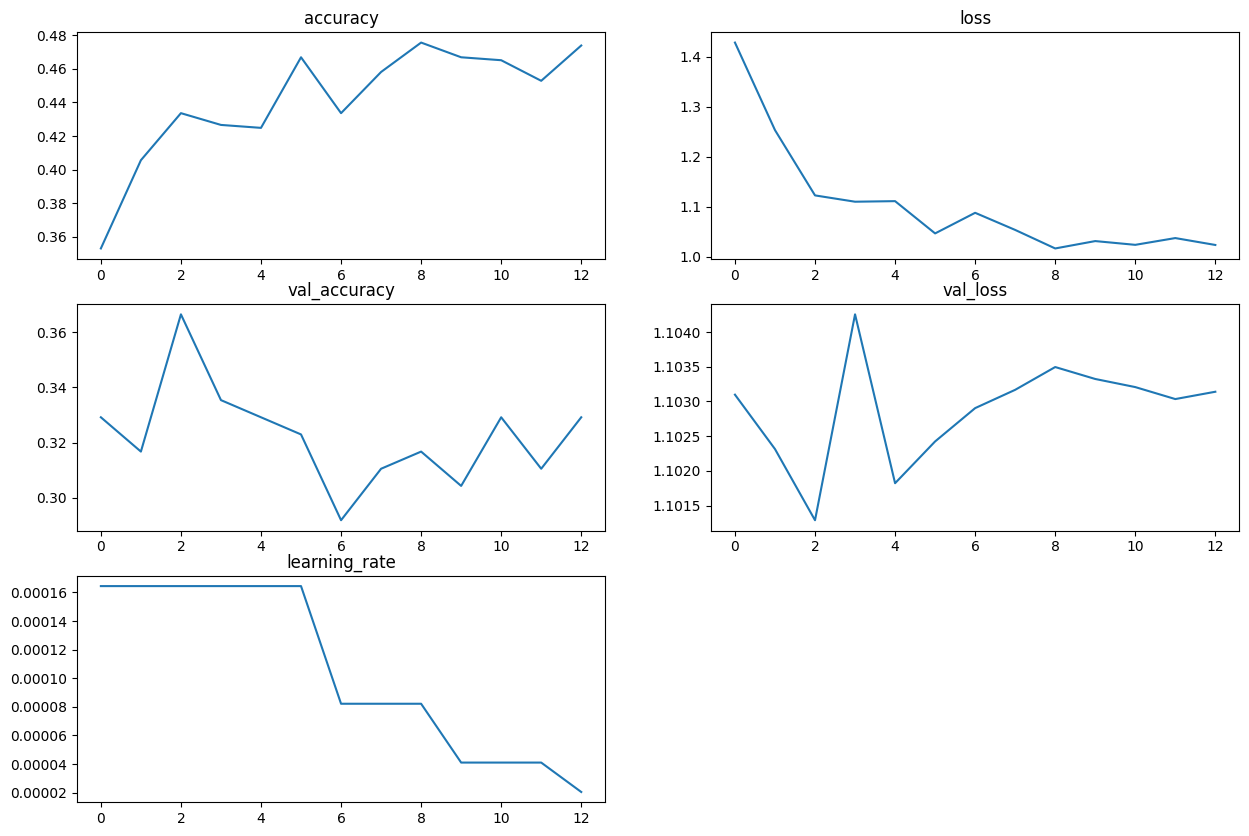

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4389 - loss: 1.1040
Test Accuracy: 0.3664596378803253


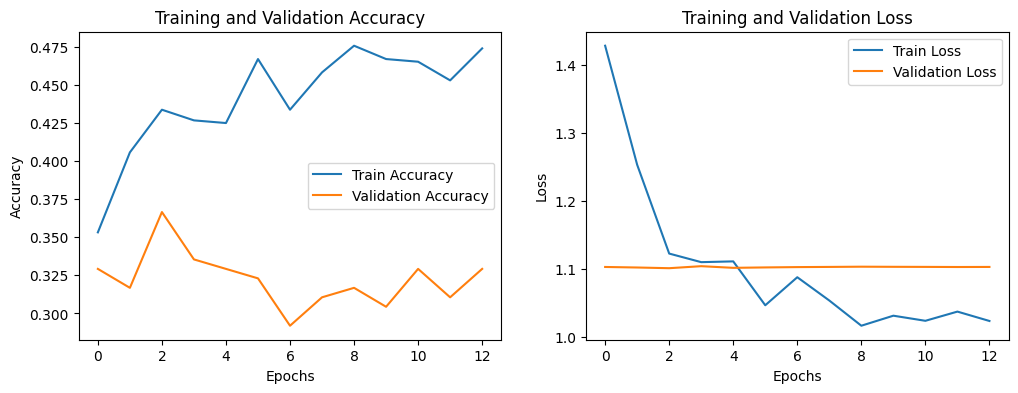

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


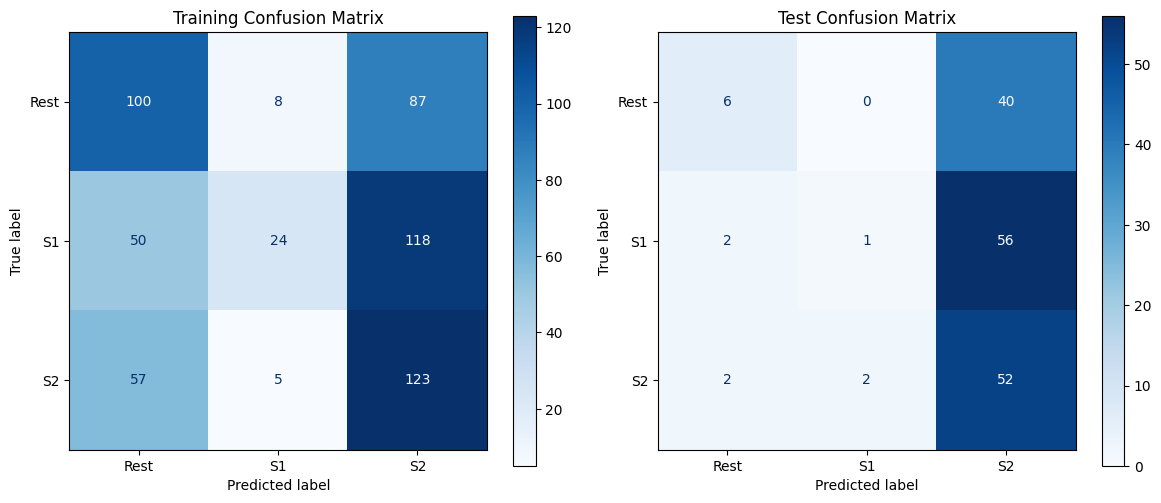

In [515]:
# Plot training history metrics
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()
    
plot_history_metrics(conv_model_history)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_list, y_test)
print("Test Accuracy:", accuracy)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(conv_model_history.history['accuracy'], label='Train Accuracy')
plt.plot(conv_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(conv_model_history.history['loss'], label='Train Loss')
plt.plot(conv_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Evaluate the model on training data to get training predictions
y_train_pred = model.predict(X_train_list)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)

# Evaluate the model on test data to get test predictions
y_test_pred = model.predict(X_test_list)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix for training data
train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
train_cmd = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=label_encoder.classes_)

# Confusion matrix for test data
test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
test_cmd = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Training Confusion Matrix')

plt.subplot(1, 2, 2)
test_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()